In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.ensemble import RandomForestClassifier

In [2]:
from stock_methods import get_data_by_hour, get_data_by_min, Stock

[*********************100%***********************]  1 of 1 completed


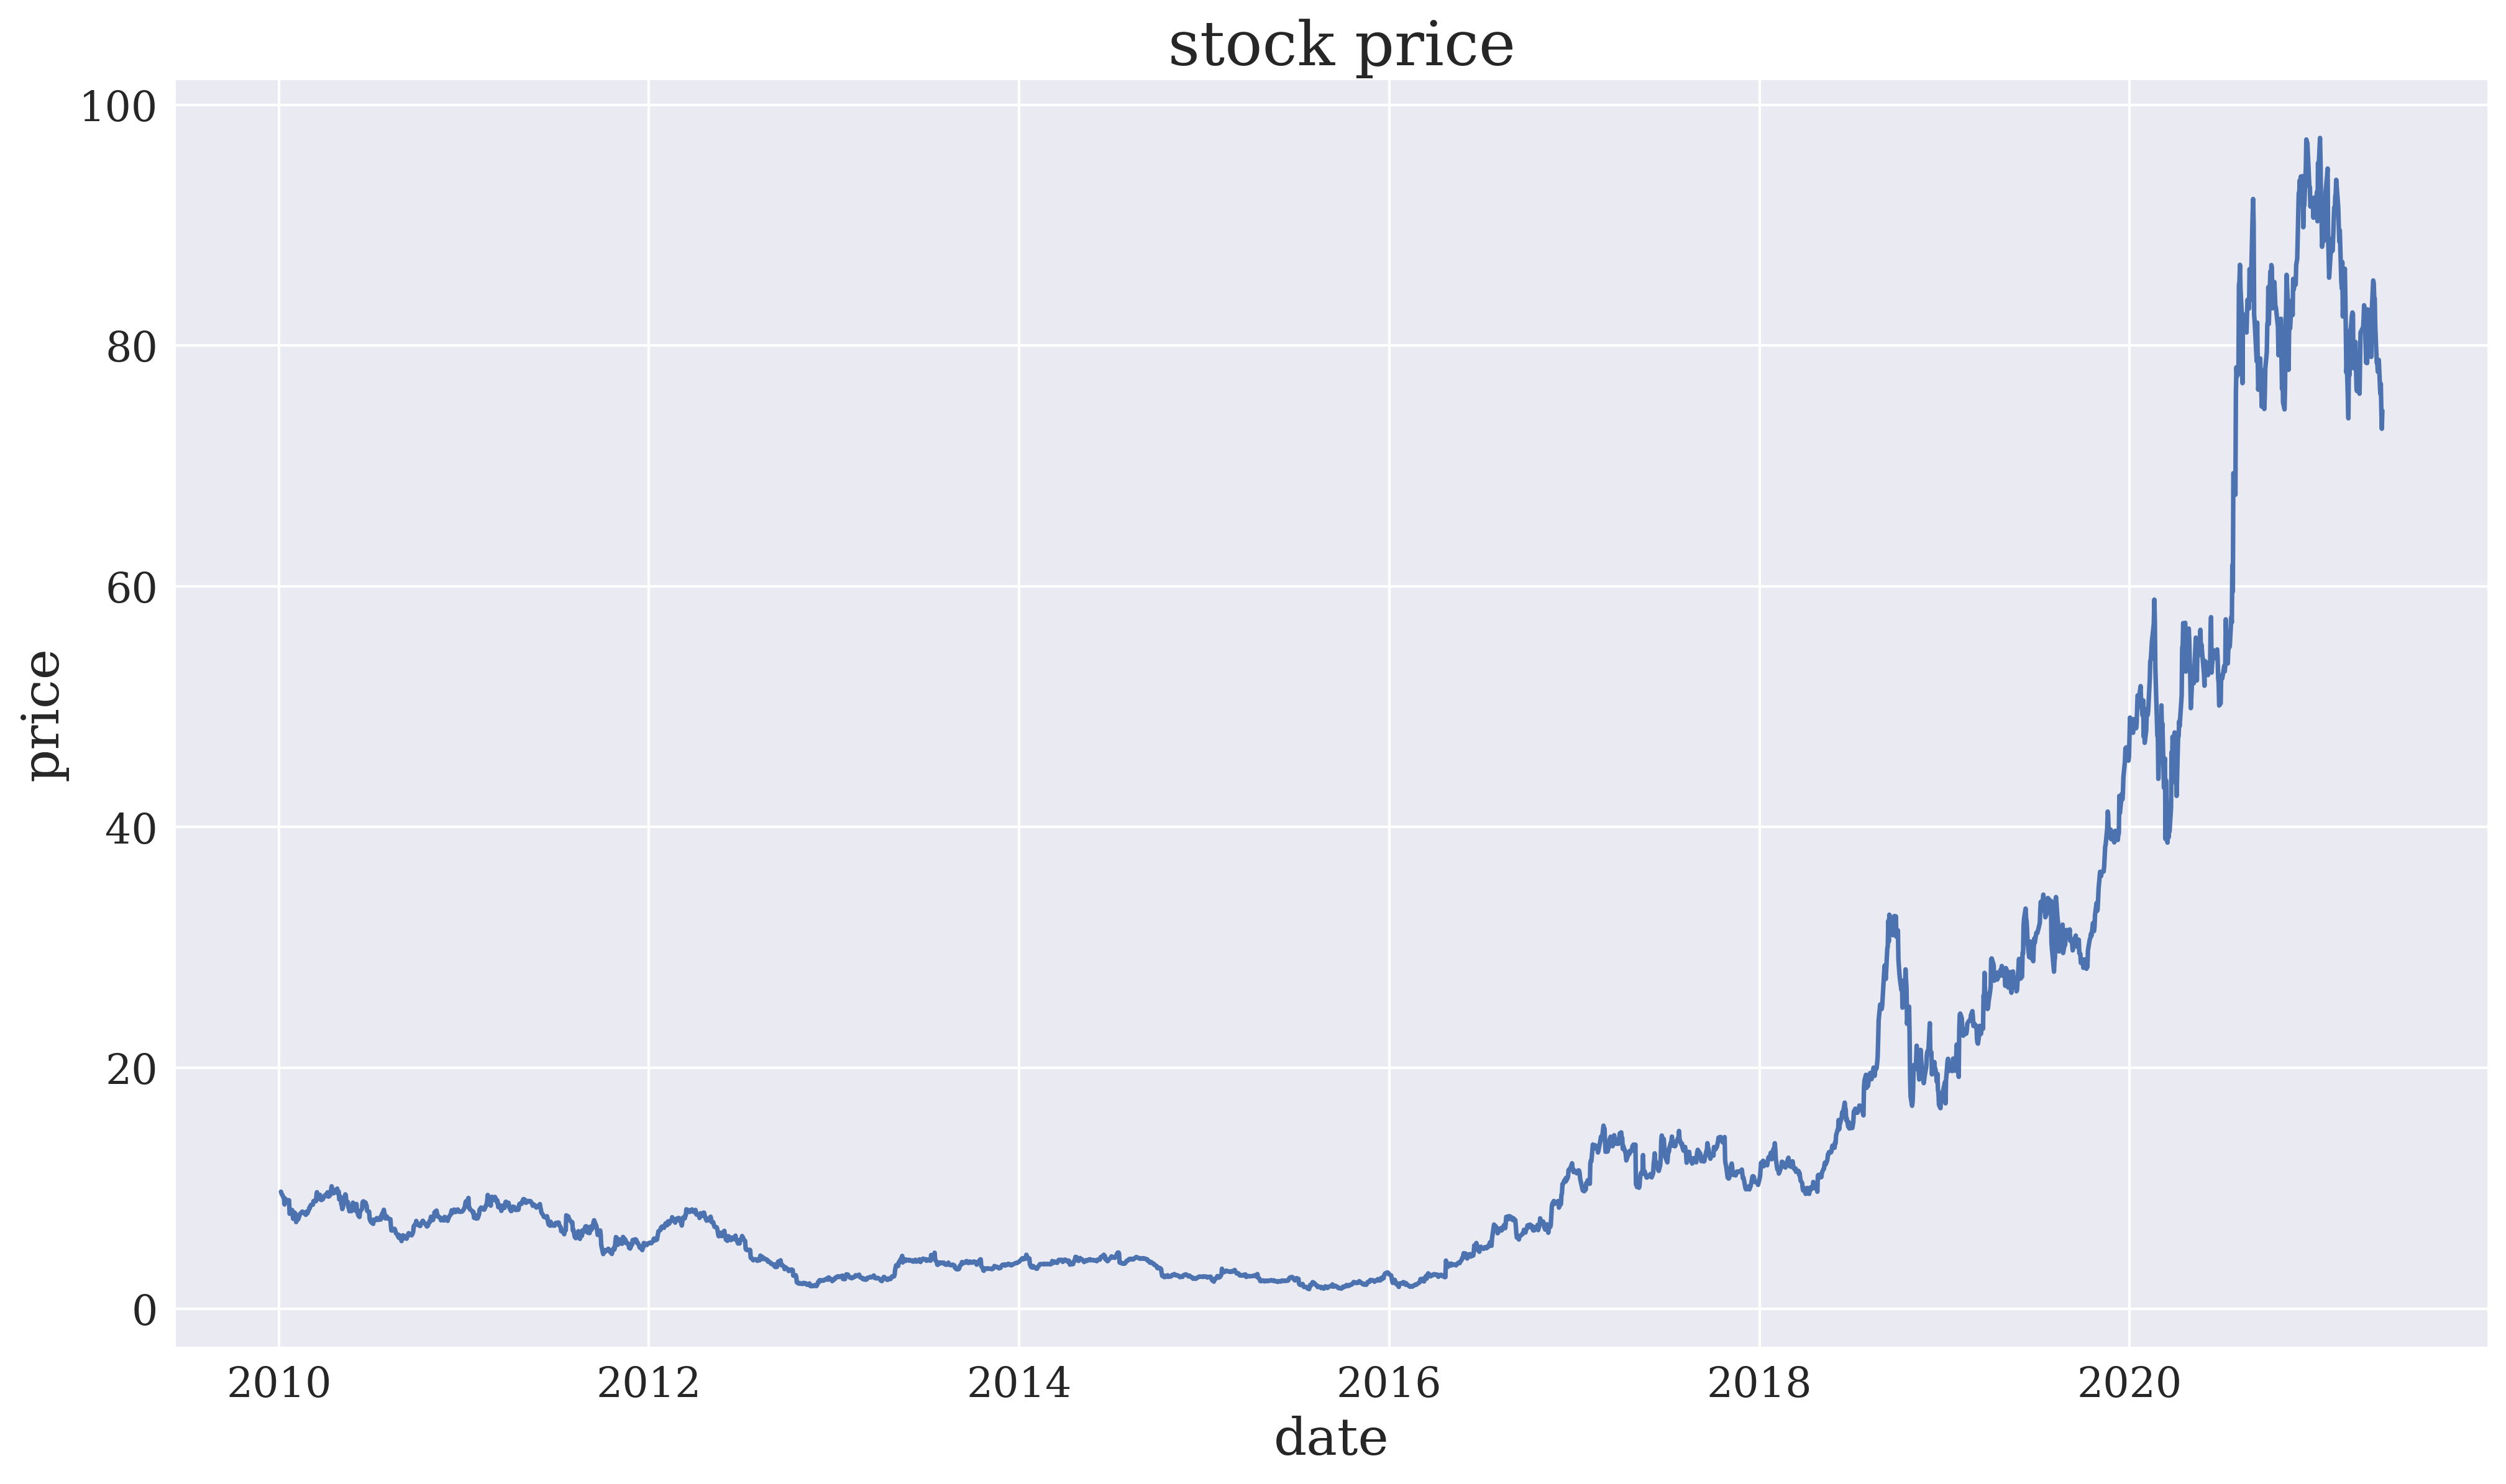

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'
import yfinance as yf
def get_data(symbols, begin_date=None,end_date=None):
    df = yf.download(symbols, start = begin_date,
                     auto_adjust=True,#only download adjusted data
                     end= end_date) 
    #my convention: always lowercase
    df.columns = ['open','high','low',
                  'close','volume'] 
    
    return df
data_stock = get_data('AMD', '2010-01-01', datetime.today().date().strftime("%Y-%m-%d"))  

data_stock.dropna(inplace=True)

price = data_stock['close']
def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0
df0 = get_Daily_Volatility(price)
def get_atr(stock, win=14):
    
    atr_df = pd.Series(index=stock.index)
    high = pd.Series(data_stock.high.rolling( \
                     win, min_periods=win))
    low = pd.Series(data_stock.low.rolling( \
                    win, min_periods=win))
    close = pd.Series(data_stock.close.rolling( \
                      win, min_periods=win))    
          
    for i in range(len(stock.index)):
        tr=np.max([(high[i] - low[i]), \
                  np.abs(high[i] - close[i]), \
                  np.abs(low[i] - close[i])], \
                  axis=0)
    atr_df[i] = tr.sum() / win
     
    return  atr_df
#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [2, 2]
#allign the index
prices = price[daily_volatility.index]

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 'price', 'vert_barrier', 'top_barrier', 'bottom_barrier'], index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc[daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', \
        'vert_barrier','top_barrier', 'bottom_barrier']] = \
         days_passed, prices.loc[day], vert_barrier, \
         top_barrier, bottom_barrier
    barriers['out'] = None
    return barriers


barriers = get_3_barriers()

def get_labels():
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
                # assign the initial and final price
                price_initial = barriers.price[start]
                price_final = barriers.price[end]
    # assign the top and bottom barriers
                top_barrier = barriers.top_barrier[i]
                bottom_barrier = barriers.bottom_barrier[i]
    #set the profit taking and stop loss conditons
                condition_pt = (barriers.price[start: end] >= \
                 top_barrier).any()
                condition_sl = (barriers.price[start: end] <= \
                 bottom_barrier).any()
    #assign the labels
                if condition_pt: 
                    barriers['out'][i] = 1
                elif condition_sl: 
                    barriers['out'][i] = -1    
                else: 
                    barriers['out'][i] = 0
    return

get_labels()

fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price)

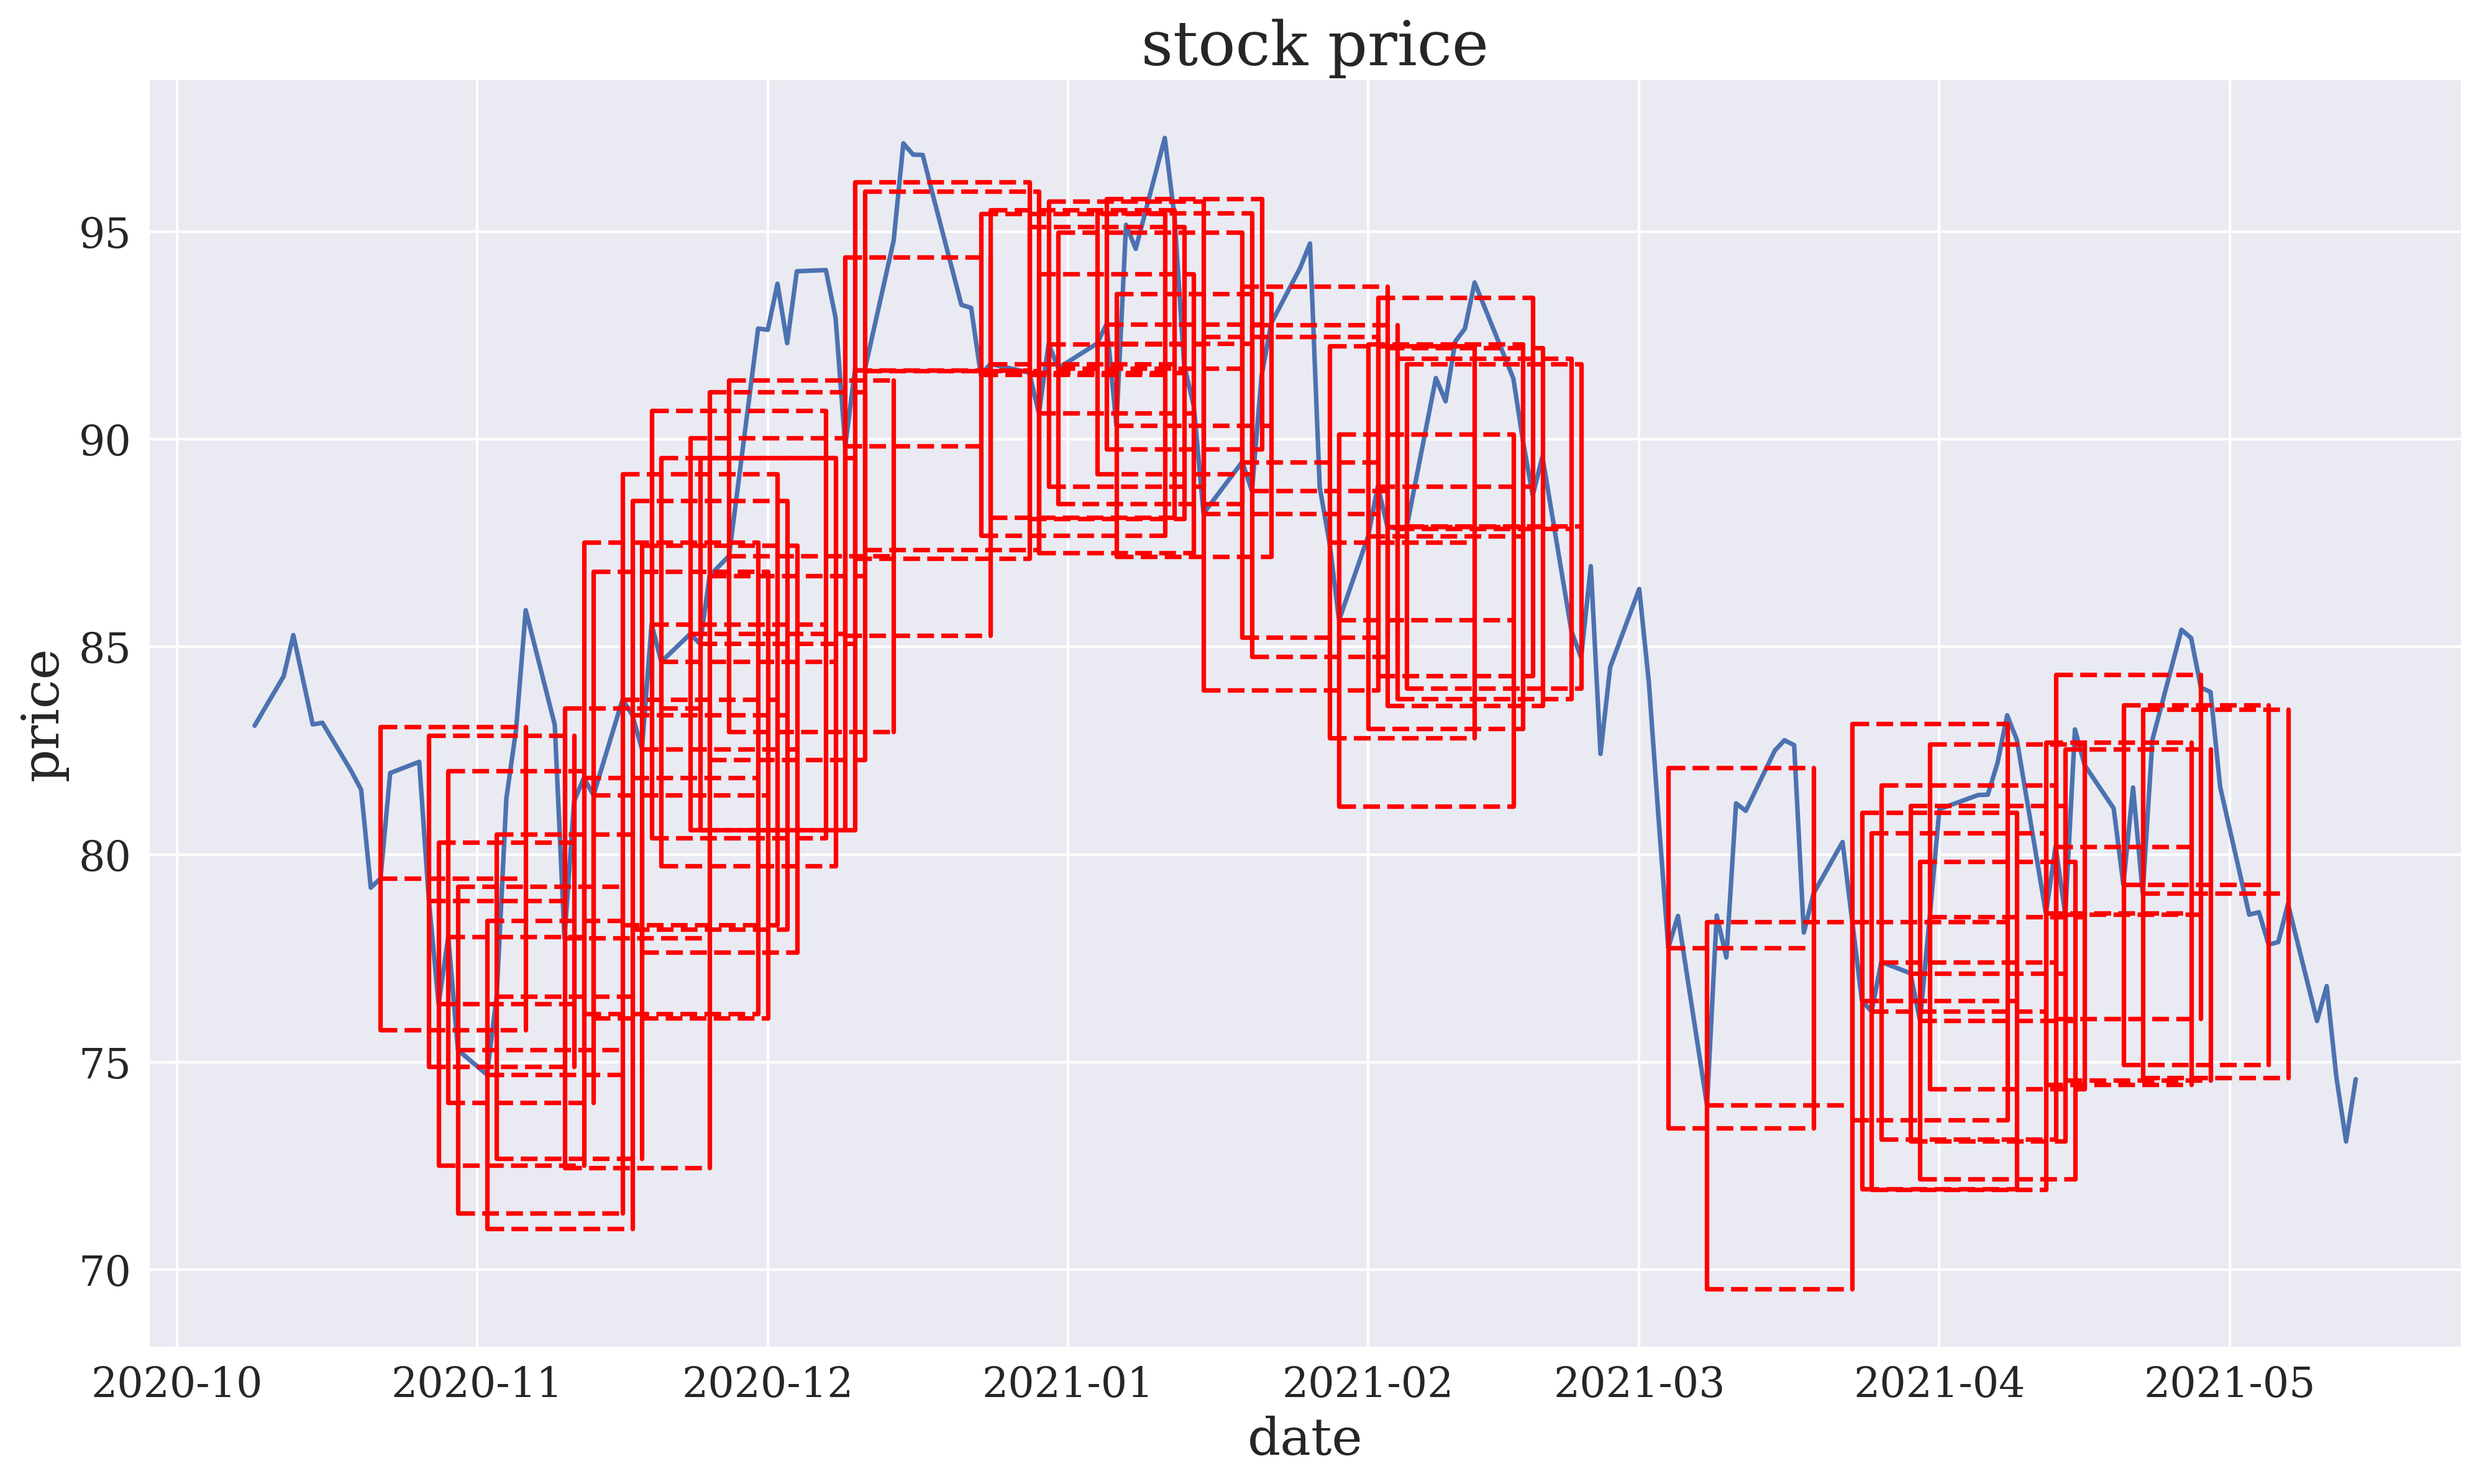

In [4]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-150:])
for i in barriers.index[-155:]:
    barrier = barriers.loc[i]
    start = i
    end = barrier.vert_barrier
    if not pd.isnull(end) and barrier.out == 1:
        upper_barrier = barrier.top_barrier
        lower_barrier = barrier.bottom_barrier
        ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
        ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
        ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
        ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
        ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [5]:
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
Date,,,,,,
2010-01-05,1,9.71,2010-01-21 00:00:00,9.724214,9.695786,-1
2010-01-06,2,9.57,2010-01-22 00:00:00,9.750686,9.389313,-1
2010-01-07,3,9.47,2010-01-25 00:00:00,9.624669,9.315332,-1
2010-01-08,4,9.43,2010-01-26 00:00:00,9.560998,9.299003,-1
2010-01-11,5,9.14,2010-01-27 00:00:00,9.373555,8.906446,-1
...,...,...,...,...,...,...
2021-05-10,2856,75.989998,NaN,79.725401,72.254595,None
2021-05-11,2857,76.830002,NaN,80.500135,73.159869,None
2021-05-12,2858,74.639999,NaN,78.210968,71.069031,None


In [6]:
def create_HLCV(i): 
    df = pd.DataFrame(index=data_stock.index)
    df[f'high_{i}'] = data_stock.high.rolling(i).max()
    df[f'low_{i}'] = data_stock.low.rolling(i).min()
    df[f'close_{i}'] = data_stock.close.rolling(i).\
                        apply(lambda x:x[-1]) 
    df[f'volume_{i}'] = data_stock.volume.rolling(i).sum()
    
    return df

In [7]:
def create_features(i):
    df = create_HLCV(i)
    high = df[f'high_{i}']
    low = df[f'low_{i}']
    close = df[f'close_{i}']
    volume = df[f'volume_{i}']
    features = pd.DataFrame(index=data_stock.index)
    features[f'volume_{i}'] = volume
    features[f'price_spread_{i}'] = high - low
    features[f'close_loc_{i}'] = (high - close) / (high - low)
    features[f'close_change_{i}'] = close.diff()
    
    return features

In [8]:
def create_bunch_of_features():
    days = [1,2,3,5,6,7,8,9,10,20,40,60]
    bunch_of_features = pd.DataFrame(index=data_stock.index)
    for day in days:
        f = create_features(day)
        bunch_of_features = bunch_of_features.join(f)
    
    return bunch_of_features

bunch_of_features = create_bunch_of_features()
bunch_of_features.info()

(array([1259]),)
(array([0]),)
(array([0, 1]),)
(array([0, 1, 2, 3]),)
(array([0, 1, 2, 3, 4]),)
(array([0, 1, 2, 3, 4, 5]),)
(array([0, 1, 2, 3, 4, 5, 6]),)
(array([0, 1, 2, 3, 4, 5, 6, 7]),)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58]),)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2862 entries, 2009-12-31 to 2021-05-14
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   volu

In [9]:
barriers.dropna(inplace=True)

In [10]:
bunch_of_features[60:-13]

,volume_1,price_spread_1,close_loc_1,close_change_1,volume_2,price_spread_2,close_loc_2,close_change_2,volume_3,price_spread_3,...,close_loc_20,close_change_20,volume_40,price_spread_40,close_loc_40,close_change_40,volume_60,price_spread_60,close_loc_60,close_change_60
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-30,13451600.0,0.190000,0.052628,0.160001,23073500.0,0.219999,0.045451,0.160001,35231600.0,0.370000,...,0.321917,0.160001,6.736445e+08,2.760000,0.170290,0.160001,1.238527e+09,2.920000,0.215753,0.160001
2010-03-31,12850100.0,0.309999,0.548385,0.000000,26301700.0,0.349999,0.485713,0.000000,35923600.0,0.379999,...,0.321917,0.000000,6.653837e+08,2.760000,0.170290,0.000000,1.232628e+09,2.920000,0.215753,0.000000
2010-04-01,11757400.0,0.270000,0.444445,0.099999,24607500.0,0.360000,0.333333,0.099999,38059100.0,0.400000,...,0.282443,0.099999,6.626192e+08,2.760000,0.134058,0.099999,1.222240e+09,2.780000,0.140288,0.099999
2010-04-05,10467800.0,0.120000,0.083335,0.160000,22225200.0,0.320000,0.031251,0.160000,35075300.0,0.410000,...,0.160305,0.160000,6.399148e+08,2.760000,0.076087,0.160000,1.214064e+09,2.760000,0.076087,0.160000
2010-04-06,18738400.0,0.309999,0.451612,-0.179999,29206200.0,0.360000,0.527777,-0.179999,40963600.0,0.360000,...,0.297710,-0.179999,6.298449e+08,2.460000,0.158536,-0.179999,1.205996e+09,2.760000,0.141304,-0.179999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,35069000.0,2.800003,0.017858,2.340004,70046800.0,3.150002,0.015874,2.340004,109162300.0,4.669998,...,0.257142,2.340004,1.724551e+09,13.229996,0.414210,2.340004,2.551670e+09,21.860001,0.645471,2.340004
2021-04-22,38846100.0,3.200005,0.853125,-2.550003,73915100.0,3.200005,0.853125,-2.550003,108892900.0,3.279999,...,0.537363,-2.550003,1.722576e+09,13.229996,0.606954,-2.550003,2.531067e+09,20.360001,0.744597,-2.550003
2021-04-23,49194000.0,3.340004,0.161677,3.700005,88040100.0,4.710007,0.114650,3.700005,123109100.0,4.710007,...,0.130769,3.700005,1.717144e+09,13.089996,0.320091,3.700005,2.506920e+09,20.360001,0.562868,3.700005


In [11]:
barriers[58:-2]

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
Date,,,,,,
2010-03-30,59,9.27,2010-04-15 00:00:00,9.684328,8.855673,1
2010-03-31,60,9.27,2010-04-16 00:00:00,9.664611,8.87539,1
2010-04-01,61,9.37,2010-04-19 00:00:00,9.751646,8.988354,1
2010-04-05,62,9.53,2010-04-20 00:00:00,9.90663,9.15337,1
2010-04-06,63,9.35,2010-04-21 00:00:00,9.727041,8.972959,1
...,...,...,...,...,...,...
2021-04-21,2843,81.610001,2021-05-06 00:00:00,86.110533,77.109468,0
2021-04-22,2844,79.059998,2021-05-07 00:00:00,83.492172,74.627823,1
2021-04-23,2845,82.760002,2021-05-10 00:00:00,87.788026,77.731978,-1


In [12]:
data = bunch_of_features[60:-13].assign(out=barriers[58:-2].out)


In [13]:
data.dropna(inplace=True)

In [14]:
data

,volume_1,price_spread_1,close_loc_1,close_change_1,volume_2,price_spread_2,close_loc_2,close_change_2,volume_3,price_spread_3,...,close_change_20,volume_40,price_spread_40,close_loc_40,close_change_40,volume_60,price_spread_60,close_loc_60,close_change_60,out
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-30,13451600.0,0.190000,0.052628,0.160001,23073500.0,0.219999,0.045451,0.160001,35231600.0,0.370000,...,0.160001,6.736445e+08,2.760000,0.170290,0.160001,1.238527e+09,2.920000,0.215753,0.160001,1
2010-03-31,12850100.0,0.309999,0.548385,0.000000,26301700.0,0.349999,0.485713,0.000000,35923600.0,0.379999,...,0.000000,6.653837e+08,2.760000,0.170290,0.000000,1.232628e+09,2.920000,0.215753,0.000000,1
2010-04-01,11757400.0,0.270000,0.444445,0.099999,24607500.0,0.360000,0.333333,0.099999,38059100.0,0.400000,...,0.099999,6.626192e+08,2.760000,0.134058,0.099999,1.222240e+09,2.780000,0.140288,0.099999,1
2010-04-05,10467800.0,0.120000,0.083335,0.160000,22225200.0,0.320000,0.031251,0.160000,35075300.0,0.410000,...,0.160000,6.399148e+08,2.760000,0.076087,0.160000,1.214064e+09,2.760000,0.076087,0.160000,1
2010-04-06,18738400.0,0.309999,0.451612,-0.179999,29206200.0,0.360000,0.527777,-0.179999,40963600.0,0.360000,...,-0.179999,6.298449e+08,2.460000,0.158536,-0.179999,1.205996e+09,2.760000,0.141304,-0.179999,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,35069000.0,2.800003,0.017858,2.340004,70046800.0,3.150002,0.015874,2.340004,109162300.0,4.669998,...,2.340004,1.724551e+09,13.229996,0.414210,2.340004,2.551670e+09,21.860001,0.645471,2.340004,0
2021-04-22,38846100.0,3.200005,0.853125,-2.550003,73915100.0,3.200005,0.853125,-2.550003,108892900.0,3.279999,...,-2.550003,1.722576e+09,13.229996,0.606954,-2.550003,2.531067e+09,20.360001,0.744597,-2.550003,1
2021-04-23,49194000.0,3.340004,0.161677,3.700005,88040100.0,4.710007,0.114650,3.700005,123109100.0,4.710007,...,3.700005,1.717144e+09,13.089996,0.320091,3.700005,2.506920e+09,20.360001,0.562868,3.700005,-1


In [15]:
np.where(pd.isnull(data))

(array([], dtype=int64), array([], dtype=int64))

In [16]:
out = data.out
out=out.astype('int')

In [17]:
data.drop('out', axis=1, inplace=True)
data

,volume_1,price_spread_1,close_loc_1,close_change_1,volume_2,price_spread_2,close_loc_2,close_change_2,volume_3,price_spread_3,...,close_loc_20,close_change_20,volume_40,price_spread_40,close_loc_40,close_change_40,volume_60,price_spread_60,close_loc_60,close_change_60
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-30,13451600.0,0.190000,0.052628,0.160001,23073500.0,0.219999,0.045451,0.160001,35231600.0,0.370000,...,0.321917,0.160001,6.736445e+08,2.760000,0.170290,0.160001,1.238527e+09,2.920000,0.215753,0.160001
2010-03-31,12850100.0,0.309999,0.548385,0.000000,26301700.0,0.349999,0.485713,0.000000,35923600.0,0.379999,...,0.321917,0.000000,6.653837e+08,2.760000,0.170290,0.000000,1.232628e+09,2.920000,0.215753,0.000000
2010-04-01,11757400.0,0.270000,0.444445,0.099999,24607500.0,0.360000,0.333333,0.099999,38059100.0,0.400000,...,0.282443,0.099999,6.626192e+08,2.760000,0.134058,0.099999,1.222240e+09,2.780000,0.140288,0.099999
2010-04-05,10467800.0,0.120000,0.083335,0.160000,22225200.0,0.320000,0.031251,0.160000,35075300.0,0.410000,...,0.160305,0.160000,6.399148e+08,2.760000,0.076087,0.160000,1.214064e+09,2.760000,0.076087,0.160000
2010-04-06,18738400.0,0.309999,0.451612,-0.179999,29206200.0,0.360000,0.527777,-0.179999,40963600.0,0.360000,...,0.297710,-0.179999,6.298449e+08,2.460000,0.158536,-0.179999,1.205996e+09,2.760000,0.141304,-0.179999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,35069000.0,2.800003,0.017858,2.340004,70046800.0,3.150002,0.015874,2.340004,109162300.0,4.669998,...,0.257142,2.340004,1.724551e+09,13.229996,0.414210,2.340004,2.551670e+09,21.860001,0.645471,2.340004
2021-04-22,38846100.0,3.200005,0.853125,-2.550003,73915100.0,3.200005,0.853125,-2.550003,108892900.0,3.279999,...,0.537363,-2.550003,1.722576e+09,13.229996,0.606954,-2.550003,2.531067e+09,20.360001,0.744597,-2.550003
2021-04-23,49194000.0,3.340004,0.161677,3.700005,88040100.0,4.710007,0.114650,3.700005,123109100.0,4.710007,...,0.130769,3.700005,1.717144e+09,13.089996,0.320091,3.700005,2.506920e+09,20.360001,0.562868,3.700005


In [18]:
out

Date
2010-03-30    1
2010-03-31    1
2010-04-01    1
2010-04-05    1
2010-04-06    1
             ..
2021-04-21    0
2021-04-22    1
2021-04-23   -1
2021-04-26   -1
2021-04-27   -1
Name: out, Length: 2788, dtype: int64

In [19]:
clf = RandomForestClassifier()
clf.fit(data, out)

RandomForestClassifier()

In [20]:
clf.predict(bunch_of_features.iloc[-5:])

array([1, 1, 1, 1, 1])

In [21]:
bunch_of_features

,volume_1,price_spread_1,close_loc_1,close_change_1,volume_2,price_spread_2,close_loc_2,close_change_2,volume_3,price_spread_3,...,close_loc_20,close_change_20,volume_40,price_spread_40,close_loc_40,close_change_40,volume_60,price_spread_60,close_loc_60,close_change_60
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,9396500.0,0.140000,0.642857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,18748700.0,0.219999,0.909093,0.020000,28145200.0,0.270000,0.740741,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,22145700.0,0.219999,0.863637,0.010000,40894400.0,0.219999,0.863637,0.010000,50290900.0,0.270000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,18643400.0,0.210000,0.904764,-0.140000,40789100.0,0.349999,0.942858,-0.140000,59537800.0,0.349999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,26806800.0,0.370000,0.216216,-0.099999,45450200.0,0.580000,0.500000,-0.099999,67595900.0,0.719999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-10,45134500.0,2.380005,0.970588,-2.820000,82066200.0,3.650002,0.980822,-2.820000,120727500.0,3.650002,...,0.994729,-2.820000,1.831168e+09,14.349998,0.920558,-2.820000,2.685095e+09,20.360001,0.895383,-2.820000
2021-05-11,51008200.0,4.180000,0.023923,0.840004,96142700.0,5.550003,0.264865,0.840004,133074400.0,6.820000,...,0.751976,0.840004,1.843089e+09,16.449997,0.751976,0.840004,2.697565e+09,21.250000,0.808000,0.840004
2021-05-12,42531400.0,1.969994,0.756347,-2.190002,93539600.0,4.180000,0.547847,-2.190002,138674100.0,5.550003,...,0.885106,-2.190002,1.842649e+09,16.449997,0.885106,-2.190002,2.704990e+09,18.209999,0.896211,-2.190002


In [22]:
data_stock

,open,high,low,close,volume
Date,,,,,
2009-12-31,9.750000,9.770000,9.630000,9.680000,9396500
2010-01-04,9.790000,9.900000,9.680000,9.700000,18748700
2010-01-05,9.710000,9.900000,9.680000,9.710000,22145700
2010-01-06,9.680000,9.760000,9.550000,9.570000,18643400
2010-01-07,9.510000,9.550000,9.180000,9.470000,26806800
...,...,...,...,...,...
2021-05-10,78.199997,78.300003,75.919998,75.989998,45134500
2021-05-11,73.570000,76.930000,72.750000,76.830002,51008200
2021-05-12,75.089996,76.129997,74.160004,74.639999,42531400


In [35]:
data_stock['high'].rolling(2).max()

Date
2009-12-31          NaN
2010-01-04     9.900000
2010-01-05     9.900000
2010-01-06     9.900000
2010-01-07     9.760000
                ...    
2021-05-10    79.570000
2021-05-11    78.300003
2021-05-12    76.930000
2021-05-13    76.129997
2021-05-14    75.699997
Name: high, Length: 2862, dtype: float64